In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("micamadi/synthetic-distributed-battery-management-system")

print("Path to dataset files:", path)

Path to dataset files: /Users/yashrajsingh/.cache/kagglehub/datasets/micamadi/synthetic-distributed-battery-management-system/versions/1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [6]:
df = pd.read_csv(path + '/distributed_bms_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.dropna()
df['module_id'] = df['module_id'].astype('category').cat.codes
print("Dataset loaded with shape:", df.shape)


Dataset loaded with shape: (600, 12)


In [7]:
print(df.describe())


        module_id  cell_voltage_v  cell_temperature_c  module_current_a  \
count  600.000000      600.000000          600.000000        600.000000   
mean     1.500000        3.700512           28.732917         20.196750   
std      1.118967        0.019868            2.177533          3.565415   
min      0.000000        3.636000           24.780000         14.090000   
25%      0.750000        3.687000           26.887500         16.747500   
50%      1.500000        3.700000           28.740000         20.335000   
75%      2.250000        3.714000           30.597500         23.712500   
max      3.000000        3.757000           32.660000         25.930000   

       module_power_kw  converter_command_pct     soc_pct     soh_pct  \
count       600.000000             600.000000  600.000000  600.000000   
mean          1.195865              10.058767   76.277150   93.505550   
std           0.211264               2.696286    2.188756    0.880655   
min           0.832000          

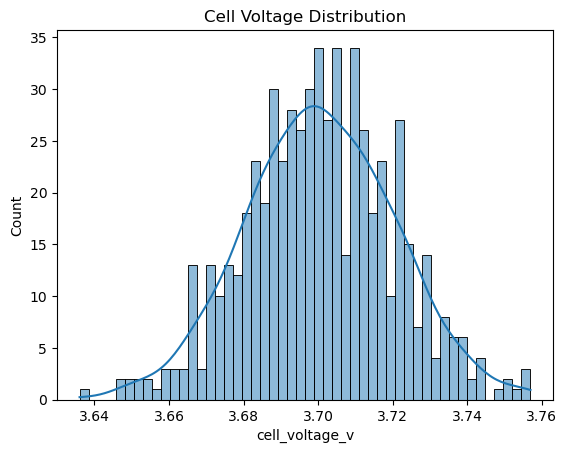

In [8]:
sns.histplot(df['cell_voltage_v'], bins=50, kde=True)
plt.title('Cell Voltage Distribution')
plt.show()


/var/folders/hs/bg0sjys12tqgftpwb7z0s8j00000gn/T/ipykernel_86805/861588669.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


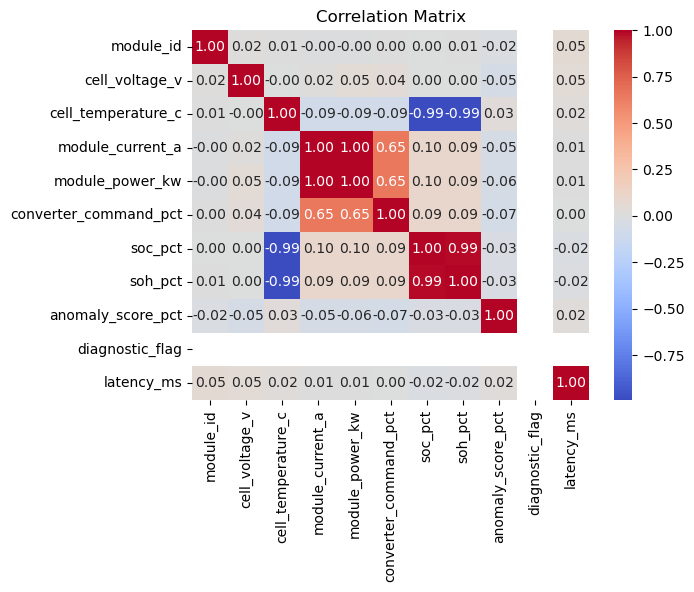

In [9]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [10]:
feature_cols = ['module_id', 'cell_voltage_v', 'cell_temperature_c', 'module_current_a',
                'module_power_kw', 'converter_command_pct', 'latency_ms']
X = df[feature_cols]
y = df['soh_pct']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [12]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
y_pred = rf_reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 0.017258446000000913
R2 Score: 0.9773954939850447


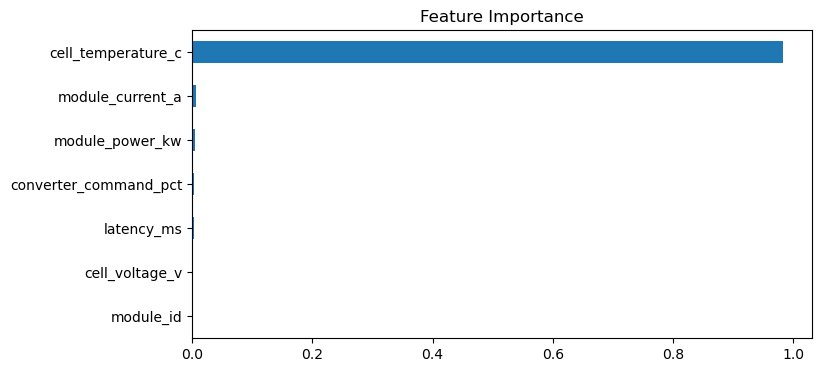

In [14]:
importances = pd.Series(rf_reg.feature_importances_, index=feature_cols).sort_values()
importances.plot(kind='barh', figsize=(8,4), title='Feature Importance')
plt.show()

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_reg, X_scaled, y, cv=kf, scoring='r2')
print(f"5-Fold CV R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores):.4f}")

5-Fold CV R2 Scores: [0.97789769 0.98025451 0.98326178 0.98300434 0.98017851]
Mean CV R2 Score: 0.9809


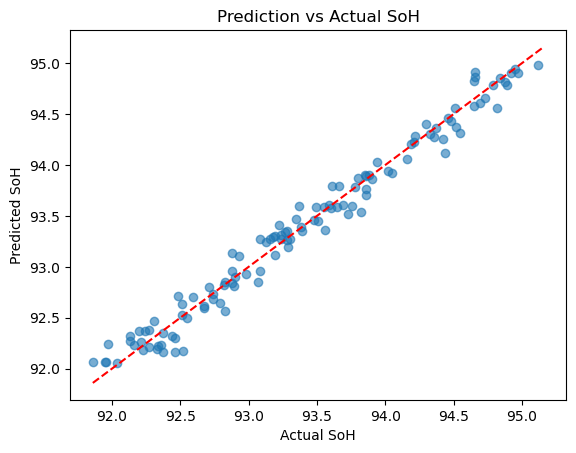

In [16]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Prediction vs Actual SoH')
plt.show()